In [ ]:
pip install dwave-ocean-sdk>=3.3.0 matplotlib dwave-system

In [ ]:
# Setup your D-Wave Leap API
!dwave config create --auto-token

Using the simplified configuration flow.
Try 'dwave config create --full' for more options.

Creating new configuration file: /root/.config/dwave/dwave.conf
Updating existing profile: defaults
Failed to fetch SAPI token from Leap API (Leap API access token not found. Please run "dwave auth login".).
Solver API token [skip]: DEV-e0718a8fea398b4ee4c3c795cf0425f82d372dd8
Configuration saved.


In [ ]:
import random
import argparse
import dimod
import sys
import networkx as nx
import numpy as np
from dwave.system import LeapHybridSampler

import matplotlib
try:
    import matplotlib.pyplot as plt
except ImportError:
    matplotlib.use("agg")
    import matplotlib.pyplot as plt

def set_up_scenario(w, h, num_poi, num_cs):
    """Build scenario set up with specified parameters.

    Args:
        w (int): Width of grid
        h (int): Height of grid
        num_poi (int): Number of points of interest
        num_cs (int): Number of existing charging stations

    Returns:
        G (networkx graph): Grid graph of size w by h
        pois (list of tuples of ints): A fixed set of points of interest
        charging_stations (list of tuples of ints):
            Set of current charging locations
        potential_new_cs_nodes (list of tuples of ints):
            Potential new charging locations
    """

    G = nx.grid_2d_graph(w, h)
    nodes = list(G.nodes)

    # Identify a fixed set of points of interest
    pois = random.sample(nodes, k=num_poi)

    # Identify a fixed set of current charging locations
    charging_stations = random.sample(nodes, k=num_cs)

    # Identify potential new charging locations
    potential_new_cs_nodes = list(G.nodes() - charging_stations)

    return G, pois, charging_stations, potential_new_cs_nodes

def distance(a, b):
    return (a[0]**2 - 2*a[0]*b[0] + b[0]**2) + (a[1]**2 - 2*a[1]*b[1] + b[1]**2)

def build_bqm(potential_new_cs_nodes, num_poi, pois, num_cs, charging_stations, num_new_cs):
    """Build bqm that models our problem scenario for the hybrid sampler.

    Args:
        potential_new_cs_nodes (list of tuples of ints):
            Potential new charging locations
        num_poi (int): Number of points of interest
        pois (list of tuples of ints): A fixed set of points of interest
        num_cs (int): Number of existing charging stations
        charging_stations (list of tuples of ints):
            Set of current charging locations
        num_new_cs (int): Number of new charging stations desired

    Returns:
        bqm_np (BinaryQuadraticModel): QUBO model for the input scenario
    """

    # Tunable parameters
    gamma1 = len(potential_new_cs_nodes) * 4
    gamma2 = len(potential_new_cs_nodes) / 3
    gamma3 = len(potential_new_cs_nodes) * 1.7
    gamma4 = len(potential_new_cs_nodes) ** 3

    # Build BQM using adjVectors to find best new charging location s.t. min
    # distance to POIs and max distance to existing charging locations
    bqm = dimod.BinaryQuadraticModel(len(potential_new_cs_nodes), 'BINARY')

    # Constraint 1: Min average distance to POIs
    if num_poi > 0:
        for i in range(len(potential_new_cs_nodes)):
            # Compute average distance to POIs from this node
            cand_loc = potential_new_cs_nodes[i]
            avg_dist = sum(distance(cand_loc, loc) for loc in pois) / num_poi
            bqm.linear[i] += avg_dist * gamma1

    # Constraint 2: Max distance to existing chargers
    if num_cs > 0:
        for i in range(len(potential_new_cs_nodes)):
            # Compute average distance to POIs from this node
            cand_loc = potential_new_cs_nodes[i]
            avg_dist = -sum(distance(cand_loc, loc)
                            for loc in charging_stations) / num_cs
            bqm.linear[i] += avg_dist * gamma2

    # Constraint 3: Max distance to other new charging locations
    if num_new_cs > 1:
        for i in range(len(potential_new_cs_nodes)):
            for j in range(i+1, len(potential_new_cs_nodes)):
                ai = potential_new_cs_nodes[i]
                aj = potential_new_cs_nodes[j]
                dist = -distance(ai, aj)
                bqm.add_interaction(i, j, dist * gamma3)

    # Constraint 4: Choose exactly num_new_cs new charging locations
    bqm.update(dimod.generators.combinations(bqm.variables, num_new_cs, strength=gamma4))

    return bqm

def run_bqm_and_collect_solutions(bqm, sampler, potential_new_cs_nodes, **kwargs):
    """Solve the bqm with the provided sampler to find new charger locations.

    Args:
        bqm (BinaryQuadraticModel): The QUBO model for the problem instance
        sampler: Sampler or solver to be used
        potential_new_cs_nodes (list of tuples of ints):
            Potential new charging locations
        **kwargs: Sampler-specific parameters to be used

    Returns:
        new_charging_nodes (list of tuples of ints):
            Locations of new charging stations
    """

    sampleset = sampler.sample(bqm,
                               label='Example - EV Charger Placement',
                               **kwargs)

    ss = sampleset.first.sample
    new_charging_nodes = [potential_new_cs_nodes[k] for k, v in ss.items() if v == 1]

    return new_charging_nodes

def printout_solution_to_cmdline(pois, num_poi, charging_stations, num_cs, new_charging_nodes, num_new_cs):
    """Print solution statistics to command line.

    Args:
        pois (list of tuples of ints): A fixed set of points of interest
        num_poi (int): Number of points of interest
        charging_stations (list of tuples of ints):
            A fixed set of current charging locations
        num_cs (int): Number of existing charging stations
        new_charging_nodes (list of tuples of ints):
            Locations of new charging stations
        num_new_cs (int): Number of new charging stations desired

    Returns:
        None.
    """

    print("\nSolution returned: \n------------------")

    print("\nNew charging locations:\t\t\t\t", new_charging_nodes)

    if num_poi > 0:
        poi_avg_dist = [0] * len(new_charging_nodes)
        for loc in pois:
            for i, new in enumerate(new_charging_nodes):
                poi_avg_dist[i] += sum(abs(a - b) for a, b in zip(new, loc)) / num_poi
        print("Average distance to POIs:\t\t\t", poi_avg_dist)

    if num_cs > 0:
        old_cs_avg_dist = [sum(abs(a - b) for a, b in zip(new, loc) for loc in charging_stations) / num_cs for new in new_charging_nodes]
        print("Average distance to old charging stations:\t", old_cs_avg_dist)

    if num_new_cs > 1:
        new_cs_dist = 0
        for i in range(num_new_cs):
            for j in range(i+1, num_new_cs):
                new_cs_dist += abs(new_charging_nodes[i][0]-new_charging_nodes[j][0])+abs(new_charging_nodes[i][1]-new_charging_nodes[j][1])
        print("Distance between new chargers:\t\t\t", new_cs_dist)

def save_output_image(G, pois, charging_stations, new_charging_nodes):
    """ Create output image of solution scenario.
            - Black nodes: available space
            - Red nodes: current charger location
            - Nodes marked 'P': POI locations
            - Blue nodes: new charger locations

    Args:
        G (networkx graph): Grid graph of size w by h
        pois (list of tuples of ints): A fixed set of points of interest
        charging_stations (list of tuples of ints):
            A fixed set of current charging locations
        new_charging_nodes (list of tuples of ints):
            Locations of new charging stations

    Returns:
        None. Output saved to file "map.png".
    """

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('New EV Charger Locations')
    pos = {x: [x[0],x[1]] for x in G.nodes()}

    # Locate POIs in map
    poi_graph = G.subgraph(pois)
    poi_labels = {x: 'P' for x in poi_graph.nodes()}

    # Locate old charging stations in map
    cs_graph = G.subgraph(charging_stations)

    # Locate old charging stations at POIs in map
    poi_cs_list = set(pois) - (set(pois)-set(charging_stations))
    poi_cs_graph = G.subgraph(poi_cs_list)
    poi_cs_labels = {x: 'P' for x in poi_graph.nodes()}

    # Draw old map (left image)
    nx.draw_networkx(G, ax=ax1, pos=pos, with_labels=False, node_color='k', font_color='w')
    nx.draw_networkx(poi_graph, ax=ax1, pos=pos, with_labels=True,
                        labels=poi_labels, node_color='k', font_color='w')
    nx.draw_networkx(cs_graph, ax=ax1, pos=pos, with_labels=False, node_color='r',
                        font_color='k')
    nx.draw_networkx(poi_cs_graph, ax=ax1, pos=pos, with_labels=True,
                        labels=poi_cs_labels, node_color='r', font_color='w')

    # Draw new map (right image)
    new_cs_graph = G.subgraph(new_charging_nodes)
    nx.draw_networkx(G, ax=ax2, pos=pos, with_labels=False, node_color='k',
                        font_color='w')
    nx.draw_networkx(poi_graph, ax=ax2, pos=pos, with_labels=True,
                        labels=poi_labels,node_color='k', font_color='w')
    nx.draw_networkx(cs_graph, ax=ax2, pos=pos, with_labels=False, node_color='r',
                        font_color='k')
    nx.draw_networkx(poi_cs_graph, ax=ax2, pos=pos, with_labels=True,
                        labels=poi_cs_labels,  node_color='r', font_color='w')
    nx.draw_networkx(new_cs_graph, ax=ax2, pos=pos, with_labels=False,
                        node_color='#00b4d9', font_color='w')

    # Save image
    plt.savefig("map.png")

In [ ]:
# Read in user-specified values
width = 15
height = 15
poi = 3
chargers = 4
new_chargers = 2
#seed = 42
# random.seed(seed)

if (width < 0) or (height < 0) or (poi < 0) or (chargers < 0) or (new_chargers < 0):
    print("All option values must be non-negative.")

if (poi > width*height) or (chargers + new_chargers > width*height):
    print("Grid size is not large enough for scenario.")


Running scenario on hybrid_binary_quadratic_model_version2 solver...

Solution returned: 
------------------

New charging locations:				 [(1, 9), (1, 4)]
Average distance to POIs:			 [7.000000000000001, 6.0]
Average distance to old charging stations:	 [5.0, 10.0]
Distance between new chargers:			 5


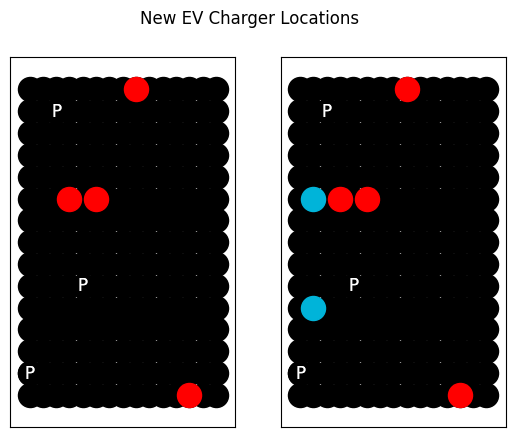

In [ ]:
G, pois, charging_stations, potential_new_cs_nodes = set_up_scenario(width, height, poi, chargers)
bqm = build_bqm(potential_new_cs_nodes, poi, pois, chargers, charging_stations, new_chargers)
sampler = LeapHybridSampler()
print("\nRunning scenario on", sampler.solver.id, "solver...")
new_charging_nodes = run_bqm_and_collect_solutions(bqm, sampler, potential_new_cs_nodes)
printout_solution_to_cmdline(pois, poi, charging_stations, chargers, new_charging_nodes, new_chargers)
save_output_image(G, pois, charging_stations, new_charging_nodes)